# **Predict change in b-cells in Tocilizumab treated samples**
In this notebook I use the models trained in the hyperparameter search in order to train BuDDI for learning the cell-type specific effect of Tocilizumab.
We use untreated single cell data from [1] and paired bulk untreated and treated (16weeks) from [2] to infer the cell-type specific treatment effect.
We specifically focus on analyzing the pathway-specific changes in each cell-type before and after treatment.

1. Zhang, F. et al. Deconstruction of rheumatoid arthritis synovium defines inflammatory subtypes. Nature 623, 616–624 (2023).
DOI:10.1038/s41586-023-06708-y

2. Rivellese, F. et al. Rituximab versus tocilizumab in rheumatoid arthritis: synovial biopsy-based biomarker analysis of the phase 4 R4RA randomized trial. Nat. Med. 28, 1256–1268 (2022).



# **Imports**

In [1]:
# import the VAE code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
from scipy.stats import rankdata, wilcoxon, ttest_ind, ttest_rel, spearmanr, pearsonr, ranksums
from sklearn.metrics import average_precision_score, f1_score, RocCurveDisplay, PrecisionRecallDisplay


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet
import anndata as ad
import gseapy as gp
from gseapy import GSEA

# programming stuff
import time
import os
import pickle
from pathlib import Path
from random import sample


# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# link to explanation why: https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/davidnat/

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_synovium_data/"
bulk_aug_data_path = f"{os.getcwd()}/../data/bulk_data/synovium/"
reference_data_path = f"{os.getcwd()}/../data/reference_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_synovium/"
clinical_file = f"{os.getcwd()}/../data/single_cell_data/synovium/metadata_clin_donor_singlecell.csv"

# results files for cibersort and bayesprism
bp_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop.tsv"
bp_00_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_00.tsv"
bp_01_bulk_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_prop_01.tsv"
bp_bulk_Z_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z.tsv"
bp_bulk_Zmeta_path = f"{os.getcwd()}/../results/single_cell_data/bp_synovium/bp_tocilizumab_Z_meta.tsv"


gmt_path_hallmark = f"{os.getcwd()}/../data/metadata/h.all.v2023.2.Hs.symbols.gmt"
gmt_path_go = f"{os.getcwd()}/../data/metadata/c5.go.bp.v2023.2.Hs.symbols.gmt"
gmt_path_reactome = f"{os.getcwd()}/../data/metadata/c2.cp.reactome.v2023.2.Hs.symbols.gmt"


cibersort_path = f"{os.getcwd()}/../data/single_cell_data/cibersort_synovium/"


cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_synovium/" +
                        "CIBERSORTx_Job42_test_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job42_test_cybersort_sig_inferred_refsample.bm.K999.txt")

num_genes = 7000

exp_id = "all-synovium"
res_id = "rittoc-synovium"
curr_treatment = "Rituximab_Tocilizumab"

RUN_CIBERSORT_GENES = False


# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 8

# number of patients/domains/samples expected
n_tot_samples = 23 # 16 bulk and 7 single cell samples -- Tocilizumab
n_tot_samples = 22 # 16 bulk and 6 single cell samples -- Tocilizumab
n_tot_samples = 24 # 16 bulk and 8 single cell samples -- Tocilizumab
n_tot_samples = 147 # 139 bulk and 8 single cell samples -- Tocilizumab

# number of drugs (in this case sexes used for prediction)
# one-hot encoded
n_drugs = 3

# number of types of sequencing (one-hot encoded)
n_tech = 2


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [4]:
in_name = f"synovium_bulk_processed_{curr_treatment}"


# read in the real bulk data
processed_sc_file = f"{bulk_aug_data_path}/{in_name}.h5ad"
adata = sc.read_h5ad(processed_sc_file)

responder_ids = ['R4RAPAT00027', 'R4RAPAT00047','R4RAPAT00060',
                'R4RAPAT00110', 'R4RAPAT00129', 'R4RAPAT00140', ]

non_responderids = [ 'R4RAPAT00056', 'R4RAPAT00066', 'R4RAPAT00072', 
                    'R4RAPAT00099', 'R4RAPAT00107', 'R4RAPAT00114', 
                    'R4RAPAT00117', 'R4RAPAT00118', 'R4RAPAT00142', 'R4RAPAT00145']



# now get the sc ref training data

# read in order
sample_order = ['BRI-462', 'BRI-458', 'BRI-460', 'BRI-421',
                'BRI-515', 'BRI-415', 'BRI-436']

#nonimmune samples
sample_order = ['BRI-460', 'BRI-462', 'BRI-515', 'BRI-601', 'BRI-605']

#immune samples
sample_order = ['BRI-415', 'BRI-421', 'BRI-436', 'BRI-458', 'BRI-566', 'BRI-623']

sample_order = ['BRI-421', 'BRI-436', 'BRI-458', 'BRI-460',
                'BRI-462', 'BRI-475', 'BRI-515', 'BRI-542']

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])


# format the bulk data
real_bulk_df = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs.index)
real_bulk_meta_df = adata.obs

# select genes that are in both
intersect_genes = np.intersect1d(gene_df, real_bulk_df.columns)
X_concat = X_concat[intersect_genes]
real_bulk_df = real_bulk_df[intersect_genes]

# now we have a new gene_df
gene_df = pd.DataFrame(intersect_genes)
gene_df.columns = ["gene_ids"]
gene_df.set_index(gene_df["gene_ids"])
gene_df = gene_df.gene_ids

# get the bulk metadata formatted
# first encode for three possible treatments
temp_real_bulk_meta_df = real_bulk_meta_df
temp_real_bulk_meta_df["drug_stim"] = "CTRL"
temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Tocilizumab"))[0]] = "toc"
temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Rituximab"))[0]] = "rit"
real_bulk_meta_df["stim"] = temp_real_bulk_meta_df["drug_stim"]



BRI-421
BRI-436
BRI-458
BRI-460
BRI-462
BRI-475
BRI-515
BRI-542


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2873410008.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Tocilizumab"))[0]] = "toc"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2873410008.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_real_bulk_meta_df.drug_stim.iloc[np.where(np.logical_and(real_bulk_meta_df.stim == "STIM", real_bulk_meta_df.treatment == "Rituximab"))[0]] = "rit"


In [5]:
real_bulk_meta_df

orig.ident  nCount_RNA  nFeature_RNA  pred_CTAP  \
R4RAPAT00002-week0            0  33092230.0         22623          0   
R4RAPAT00013-week0            0  34079591.0         20636          2   
R4RAPAT00094-week16           0  27063594.0         22532          4   
R4RAPAT00095-week0            0  17119043.0         23105          5   
R4RAPAT00096-week0            0  14005488.0         23042          0   
...                         ...         ...           ...        ...   
R4RAPAT00091-week16           0  32401360.0         22838          5   
R4RAPAT00092-week0            0  41784647.0         21493          1   
R4RAPAT00093-week0            0  36312961.0         21204          1   
R4RAPAT00093-week16           0  18487825.0         22784          5   
R4RAPAT00094-week0            0  39952241.0         23290          1   

                    sample_name   ena_sample   biosd_sample     sample_id  \
R4RAPAT00002-week0     Sample 1  ERS11589556  SAMEA13989176  R4RAPAT00002   
R4RAPAT00013-week0    Sample 10  ERS11589557  SAMEA13989177  R4RAPAT00013   
R4RAPAT00094-week16  Sample 100  ERS11589558  SAMEA13989178  R4RAPAT00094   
R4RAPAT00095-week0   Sample 101  ERS11589559  SAMEA13989179  R4RAPAT00095   
R4RAPAT00096-week0   Sample 102  ERS11589560  SAMEA13989180  R4RAPAT00096   
...                         ...          ...            ...           ...   
R4RAPAT00091-week16   Sample 95  ERS11589737  SAMEA13989357  R4RAPAT00091   
R4RAPAT00092-week0    Sample 96  ERS11589738  SAMEA13989358  R4RAPAT00092   
R4RAPAT00093-week0    Sample 97  ERS11589739  SAMEA13989359  R4RAPAT00093   
R4RAPAT00093-week16   Sample 98  ERS11589740  SAMEA13989360  R4RAPAT00093   
R4RAPAT00094-week0    Sample 99  ERS11589741  SAMEA13989361  R4RAPAT00094   

                         organism    individual  ... unit_time_unit_2  \
R4RAPAT00002-week0   Homo sapiens  R4RAPAT00002  ...             week   
R4RAPAT00013-week0   Homo sapiens  R4RAPAT00013  ...             week   
R4RAPAT00094-week16  Homo sapiens  R4RAPAT00094  ...             week   
R4RAPAT00095-week0   Homo sapiens  R4RAPAT00095  ...             week   
R4RAPAT00096-week0   Homo sapiens  R4RAPAT00096  ...             week   
...                           ...           ...  ...              ...   
R4RAPAT00091-week16  Homo sapiens  R4RAPAT00091  ...             week   
R4RAPAT00092-week0   Homo sapiens  R4RAPAT00092  ...             week   
R4RAPAT00093-week0   Homo sapiens  R4RAPAT00093  ...             week   
R4RAPAT00093-week16  Homo sapiens  R4RAPAT00093  ...             week   
R4RAPAT00094-week0   Homo sapiens  R4RAPAT00094  ...             week   

                    term_source_ref_6 term_accession_number_6   entropy  \
R4RAPAT00002-week0                EFO              UO_0000034  0.950271   
R4RAPAT00013-week0                EFO              UO_0000034  0.673012   
R4RAPAT00094-week16               EFO              UO_0000034  0.500402   
R4RAPAT00095-week0                EFO              UO_0000034  0.500402   
R4RAPAT00096-week0                EFO              UO_0000034  0.950271   
...                               ...                     ...       ...   
R4RAPAT00091-week16               EFO              UO_0000034  0.500402   
R4RAPAT00092-week0                EFO              UO_0000034  0.673012   
R4RAPAT00093-week0                EFO              UO_0000034  0.673012   
R4RAPAT00093-week16               EFO              UO_0000034 -0.000000   
R4RAPAT00094-week0                EFO              UO_0000034  0.950271   

                          CV1       CV2    treatment  stim paired_samp  \
R4RAPAT00002-week0   0.337867 -0.181978  Tocilizumab  CTRL    unpaired   
R4RAPAT00013-week0  -0.678607  0.191517    Rituximab  CTRL    unpaired   
R4RAPAT00094-week16  0.186492  0.216549    Rituximab   rit      paired   
R4RAPAT00095-week0   0.564162  0.061935  Tocilizumab  CTRL    unpaired   
R4RAPAT00096-week0   0.151749 -0.133618  Tocilizumab  CTRL    unpaired   
...      

In [6]:

real_bulk_meta_df['response'] = real_bulk_meta_df['cdai_response_status'].astype(str)
real_bulk_meta_df['paired'] = real_bulk_meta_df['paired_samp'].astype(str)
real_bulk_meta_df = real_bulk_meta_df[["sample_id", "stim", "response", "paired", "treatment"]]
real_bulk_meta_df["isTraining"] = "Train"
real_bulk_meta_df["cell_prop_type"] = "realistic"
real_bulk_meta_df["samp_type"] = "bulk"
real_bulk_meta_df['sample_id'] = real_bulk_meta_df['sample_id'].astype(str)

meta_concat['response'] = 'Non.Responder'
meta_concat['paired'] = 'unpaired'
meta_concat['treatment'] = 'CTRL'


# put the reference singlecell and real bulk it all together
X_full = pd.concat([X_concat, real_bulk_df])
Y_full = pd.concat([Y_concat, Y_concat.iloc[range(real_bulk_df.shape[0])]]) ## stop gap for now
meta_df = pd.concat([meta_concat, real_bulk_meta_df])

# add clinical info
clinical_df = pd.read_csv(clinical_file)
clinical_df = meta_df.merge(clinical_df, left_on="sample_id", right_on="mRNA_run", how='left')
meta_df = clinical_df

# index for checking correlations
sc_idx = np.where(meta_df.samp_type != "bulk")[0]
bulk_idx = np.where(meta_df.samp_type == "bulk")[0]


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2389613572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["isTraining"] = "Train"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2389613572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_bulk_meta_df["cell_prop_type"] = "realistic"
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2389613572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [7]:
tab = meta_df.groupby(['samp_type', 'response']).size()
tab.unstack()

response   Non.Responder  Responder
samp_type                          
bulk               100.0       84.0
sc_ref           14400.0        NaN

### format sample indices and get variable genes

In [8]:
meta_df.isTraining.unique()

array(['Train'], dtype=object)

In [9]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_drug = np.asarray(meta_df.stim)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining!="Train")[0] 
idx_bulk = np.where(meta_df.samp_type == "bulk")[0]
idx_sc = np.where(meta_df.samp_type != "bulk")[0]
idx_drug = np.where(meta_df.stim != "STIM")[0]
idx_random = np.where(meta_df.cell_prop_type == "random")[0]

Y_max = np.copy(Y_full)
Y_max = np.argmax(Y_max, axis=1)
Y_max = Y_full.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(gene_df, cibersort_genes)


# add in IL6
cibersort_genes = np.union1d(["IL6"], cibersort_genes)


# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# CIBERSORTx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, cibersort_genes)
    #CoV_only = top_gene_df
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 7000
gene_df = gene_df.iloc[idx_top]


In [10]:
X_orig

array([[2.0000e+01, 5.0000e+00, 3.1700e+03, ..., 6.2000e+01, 1.7200e+02,
        4.6000e+01],
       [2.1000e+01, 2.0000e+00, 2.9770e+03, ..., 7.4000e+01, 9.6000e+01,
        3.7000e+01],
       [3.2000e+01, 4.0000e+00, 3.7200e+03, ..., 5.9000e+01, 2.1000e+02,
        6.1000e+01],
       ...,
       [3.1300e+02, 4.5000e+01, 2.9257e+04, ..., 9.0400e+02, 1.1214e+04,
        2.7720e+03],
       [3.7600e+02, 5.0000e+01, 5.9200e+03, ..., 7.0500e+02, 4.7120e+03,
        1.9540e+03],
       [3.6000e+02, 2.9000e+01, 3.6597e+04, ..., 1.5550e+03, 6.8600e+03,
        4.4080e+03]])

In [11]:
X_CoV.shape

(16331,)

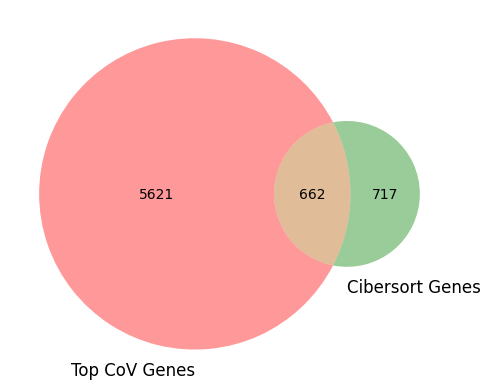

In [12]:
venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [13]:
union_genes = np.union1d(gene_df, cibersort_genes)
len(union_genes)

7000

In [14]:
np.any(np.isin(union_genes, ["PRDM1"]))

True

### normalize

In [15]:
X_full = X_full.loc[:,union_genes]

# rescale sc_ref and bulks
median_sc_ref = np.median(np.quantile(X_full.iloc[sc_idx], axis=1, q=0.9))
median_bulk = np.median(np.quantile(X_full.iloc[bulk_idx], axis=1, q=0.9))

ratio_medians = median_bulk/median_sc_ref

X_full.iloc[sc_idx] = X_full.iloc[sc_idx]*ratio_medians


In [16]:

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
idx_bulk_train = np.intersect1d(idx_bulk, idx_train) 
X_unkp = X_full[idx_bulk_train,]
label_unkp = label_full[idx_bulk_train,]
drug_unkp = drug_full[idx_bulk_train,]
bulk_unkp = bulk_full[idx_bulk_train,]
y_unkp = Y_full.iloc[idx_bulk_train]
y_unkp = y_unkp.to_numpy()

# for known proportions
idx_sc_train = np.intersect1d(idx_sc, idx_train) 
X_kp = X_full[idx_sc_train,]
label_kp = label_full[idx_sc_train,]
drug_kp = drug_full[idx_sc_train,]
bulk_kp = bulk_full[idx_sc_train,]
y_kp = Y_full.iloc[idx_sc_train]
y_kp = y_kp.to_numpy()


### plot data

In [17]:
idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)
idx_tmp

array([10471, 10229,  4742, ...,  7943,  4691, 13566])

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 2.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.187771
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.202209
[t-SNE] KL divergence after 500 iterations: 1.015497
(5000, 2)
(5000, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2600809812.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


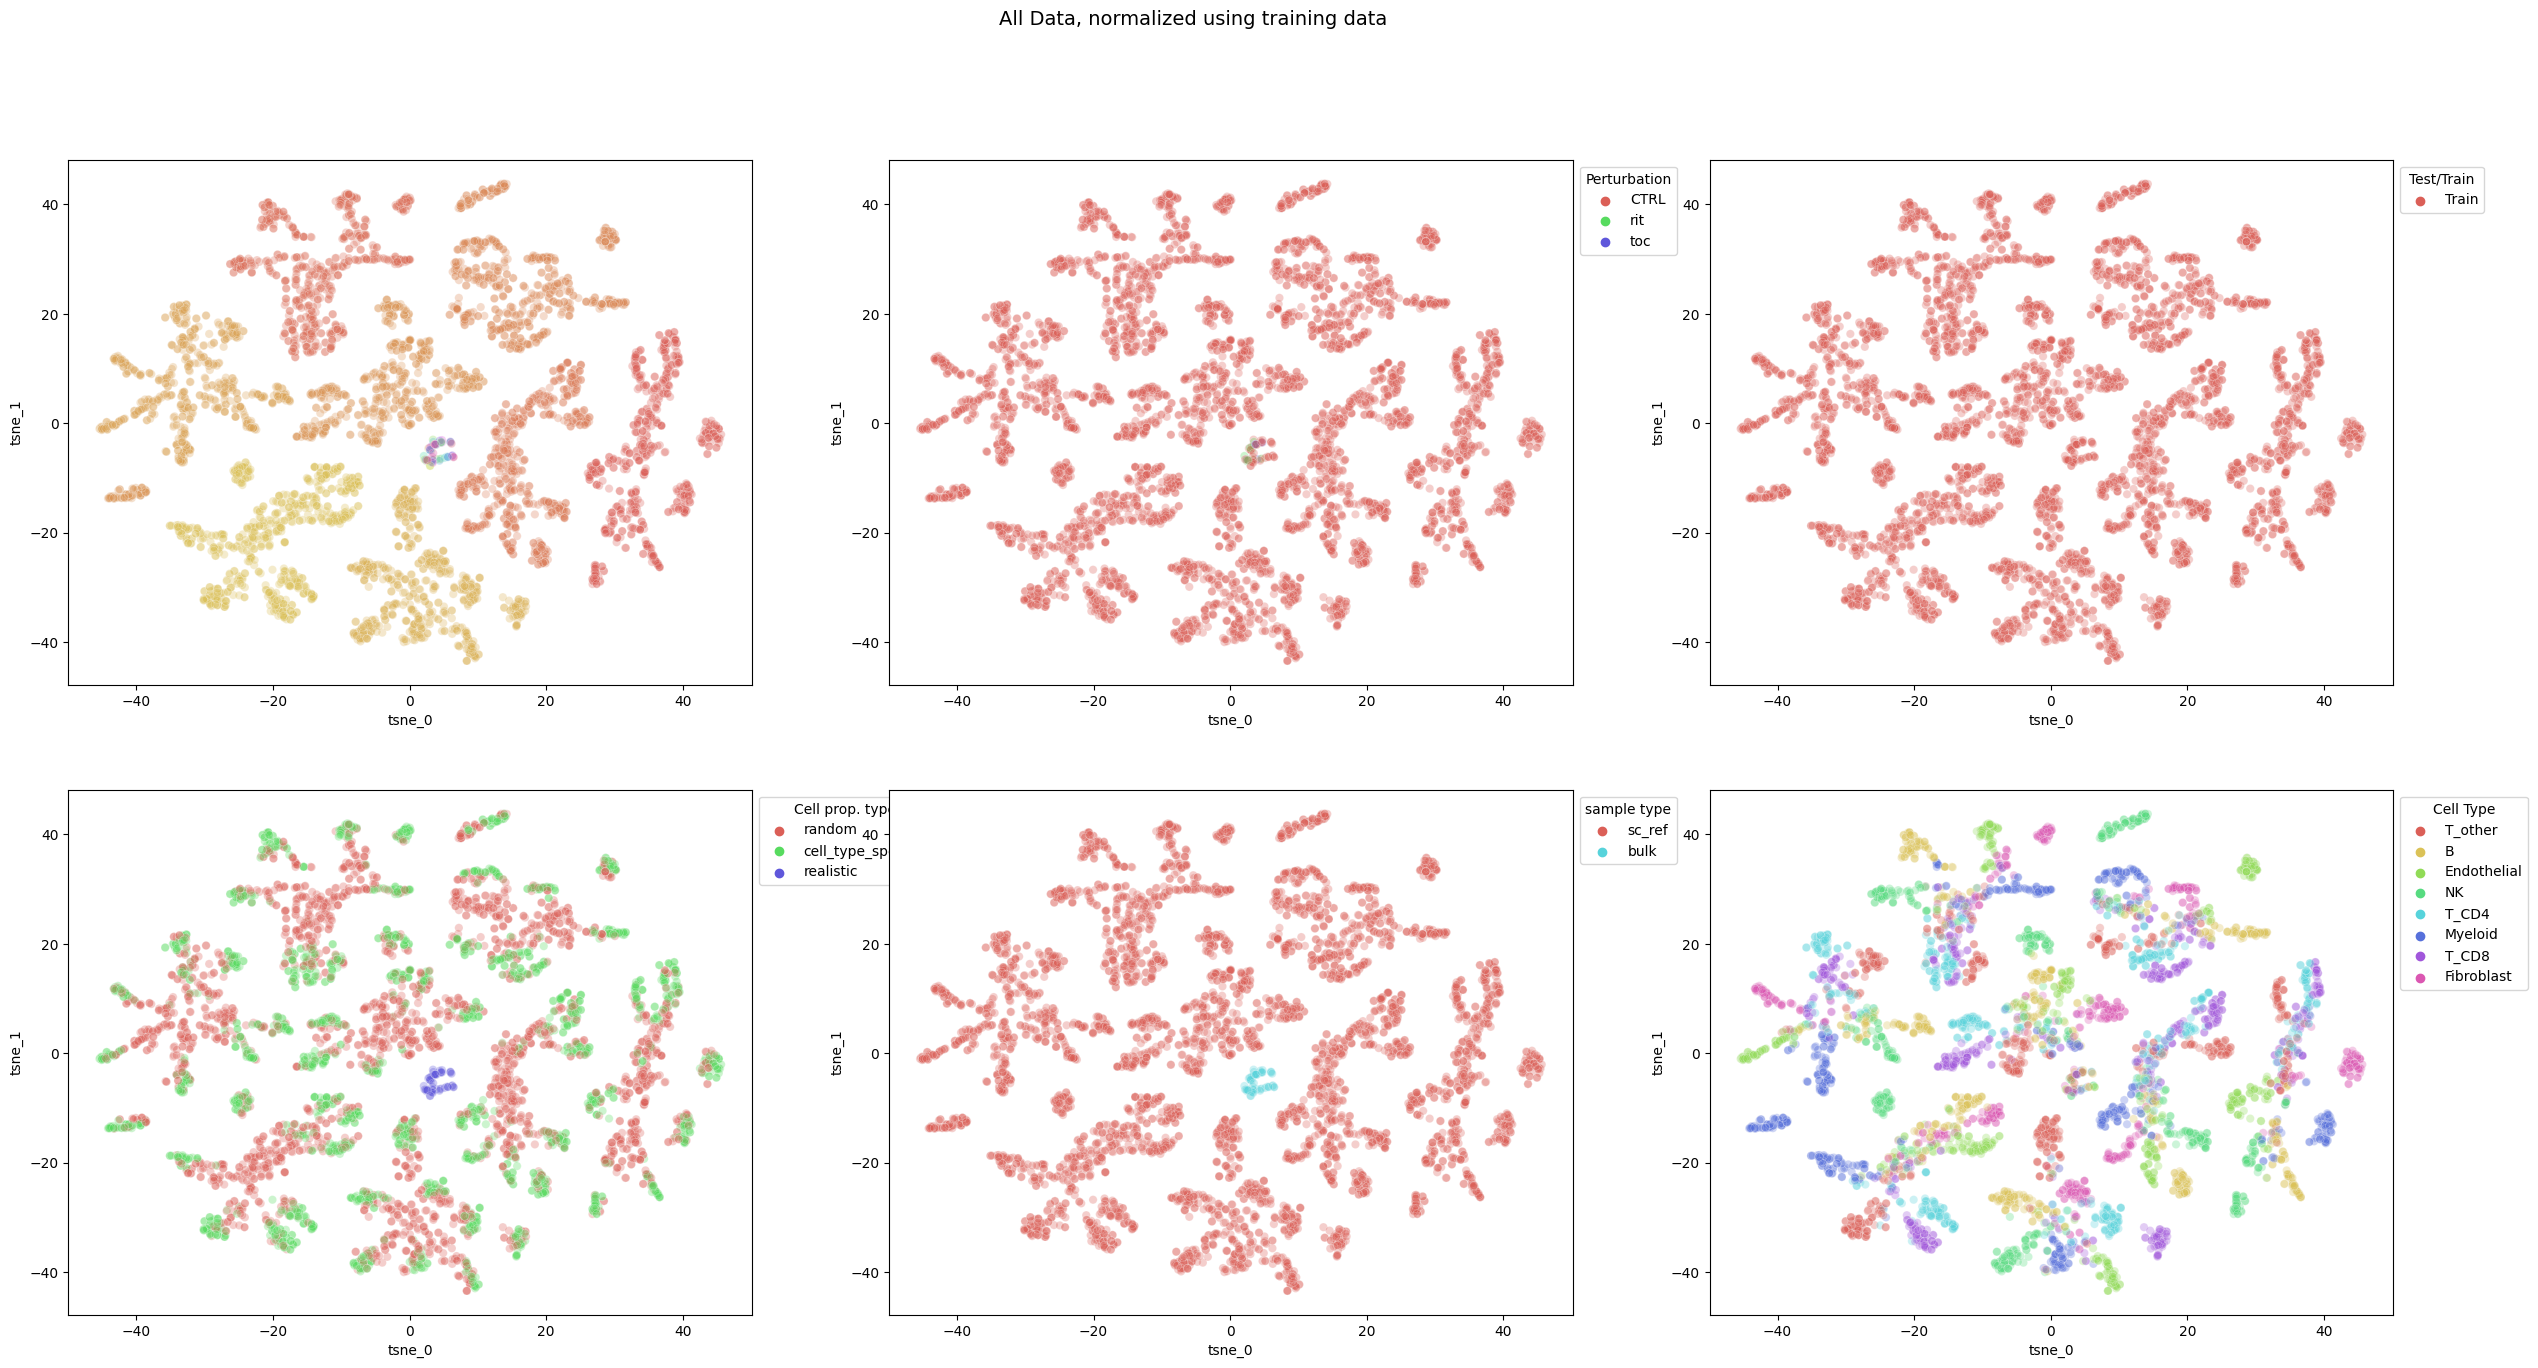

In [18]:
## plot samples

idx_tmp = np.random.choice(range(X_full.shape[0]), 5000, replace=True)

plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

# this is a vector that represents the cell-type with 
# the highest proportion 
Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]


vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


(184, 2)
(184, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2821073111.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


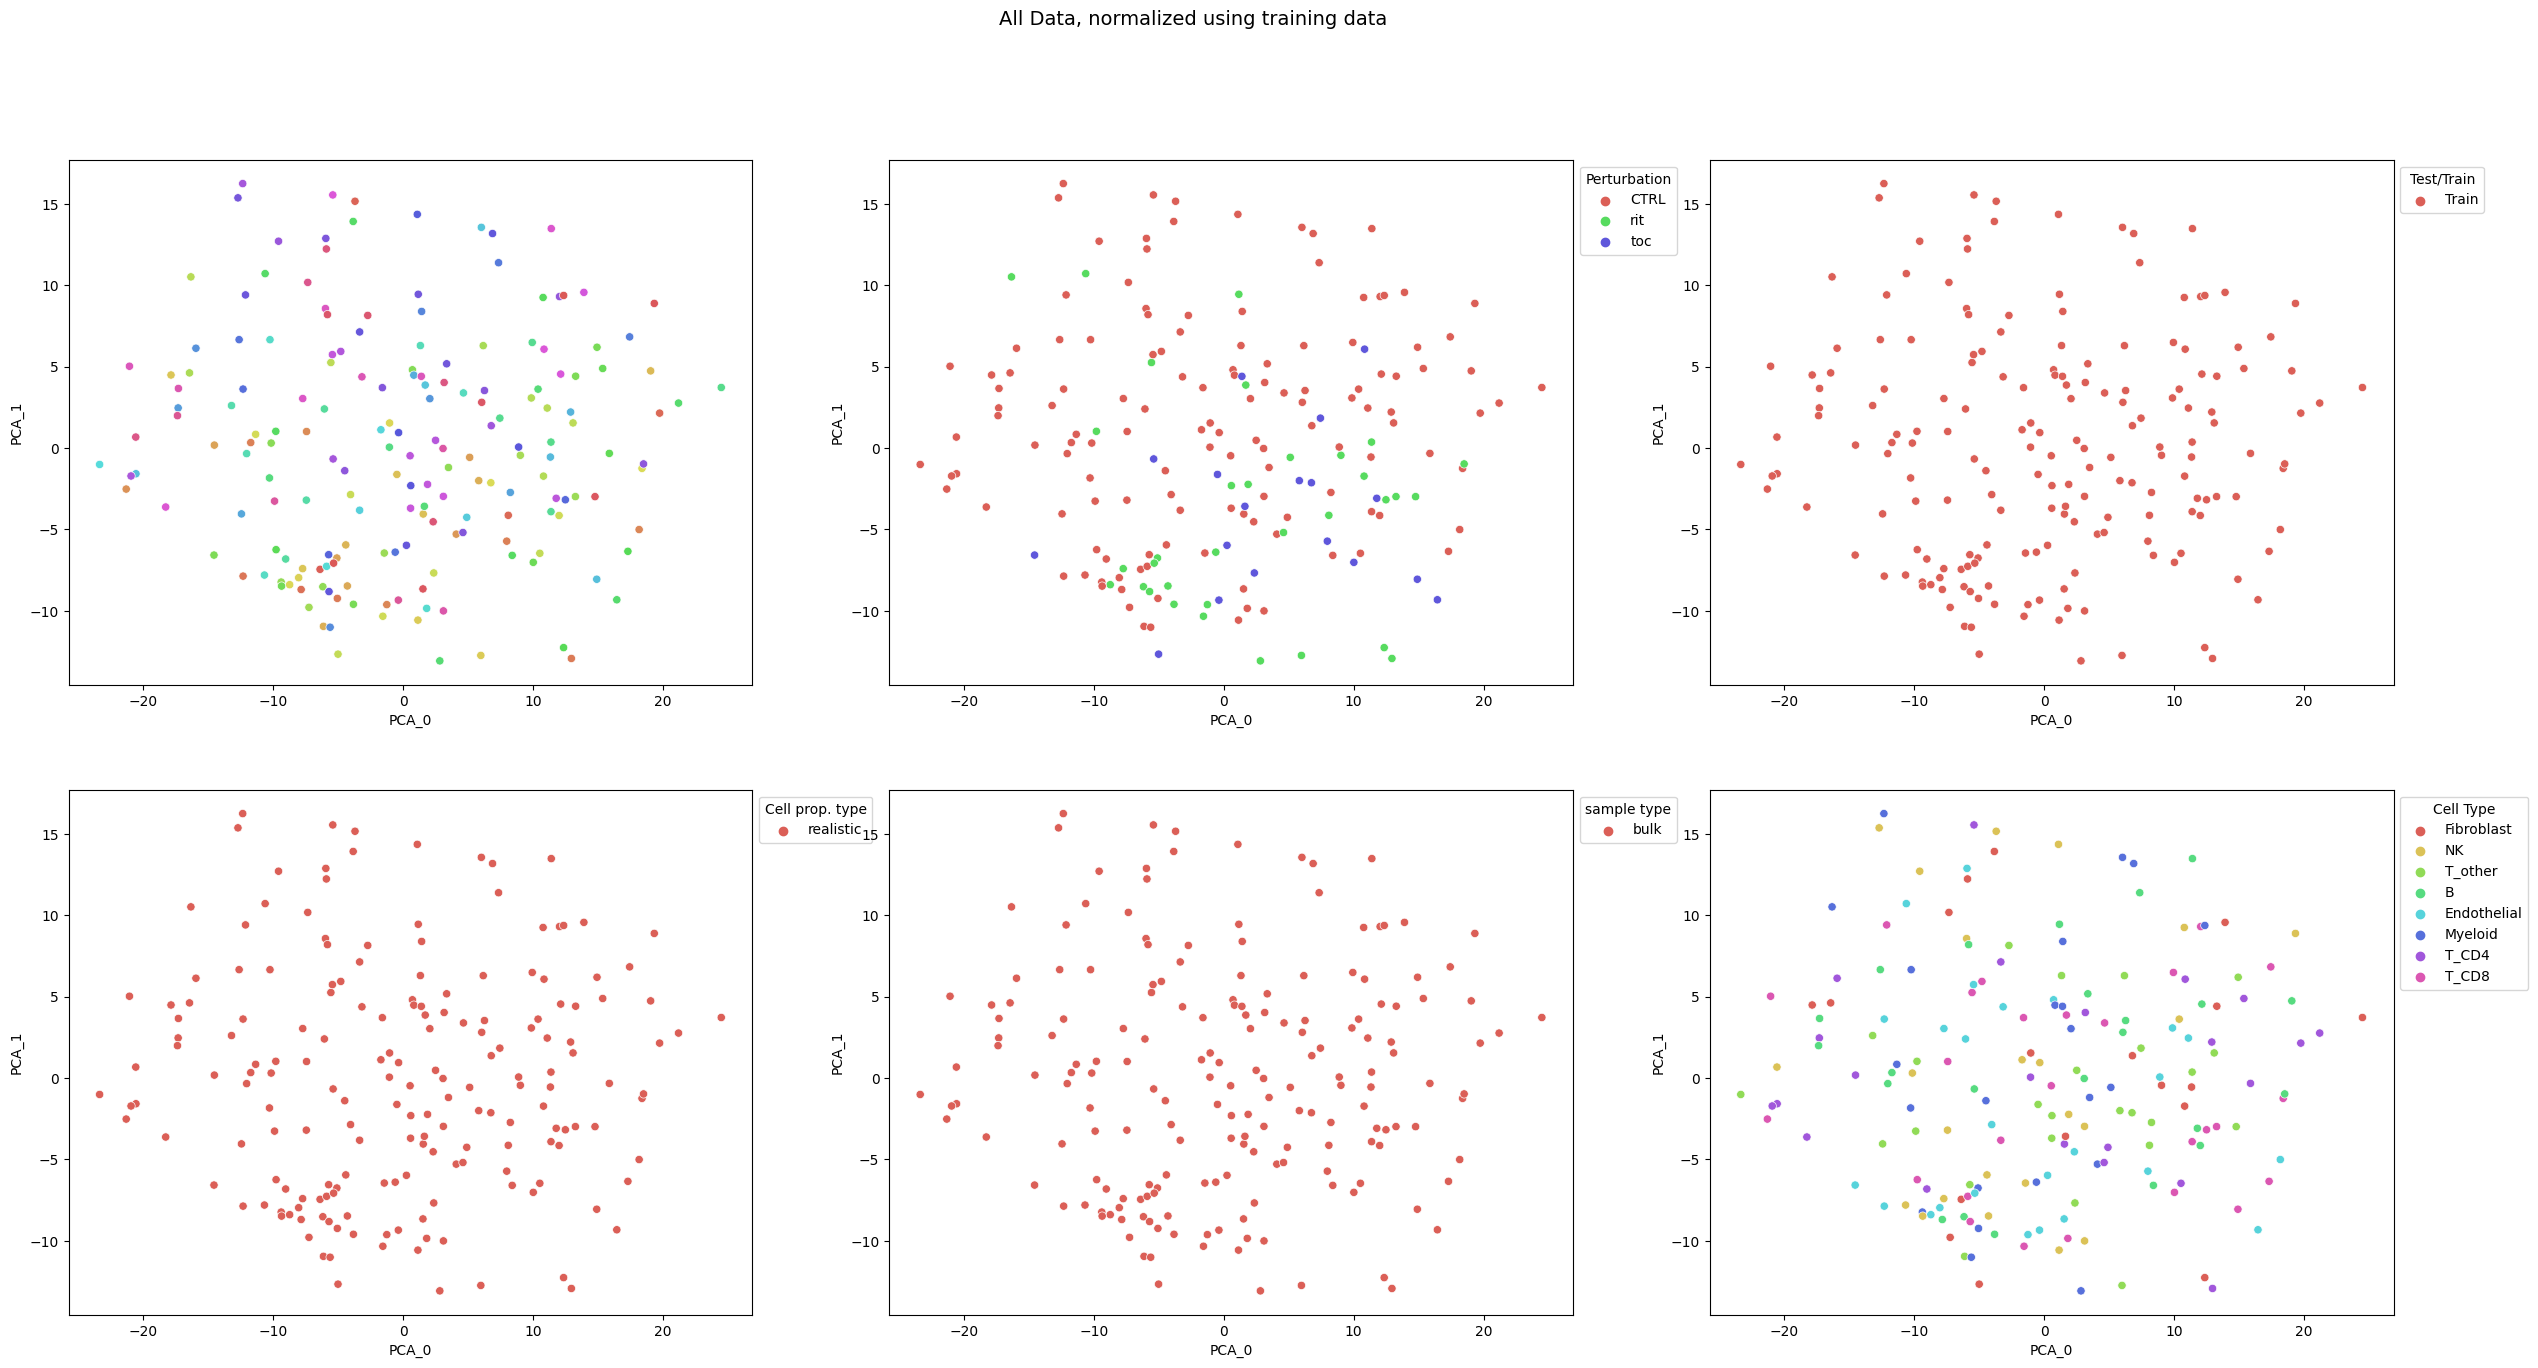

In [19]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_pca_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_pca(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], title=f"", alpha=1, legend_title="Sample ID")
vp.plot_pca(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], title=f"", alpha=1, legend_title="Perturbation")
vp.plot_pca(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], title=f"", alpha=1, legend_title="Test/Train")
vp.plot_pca(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], title=f"", alpha=1, legend_title="Cell prop. type")
vp.plot_pca(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], title=f"", alpha=1, legend_title="sample type")
vp.plot_pca(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.000s...
[t-SNE] Computed neighbors for 184 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 6.089274
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.562107
[t-SNE] KL divergence after 500 iterations: 0.601591
(184, 2)
(184, 2)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/2955274557.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


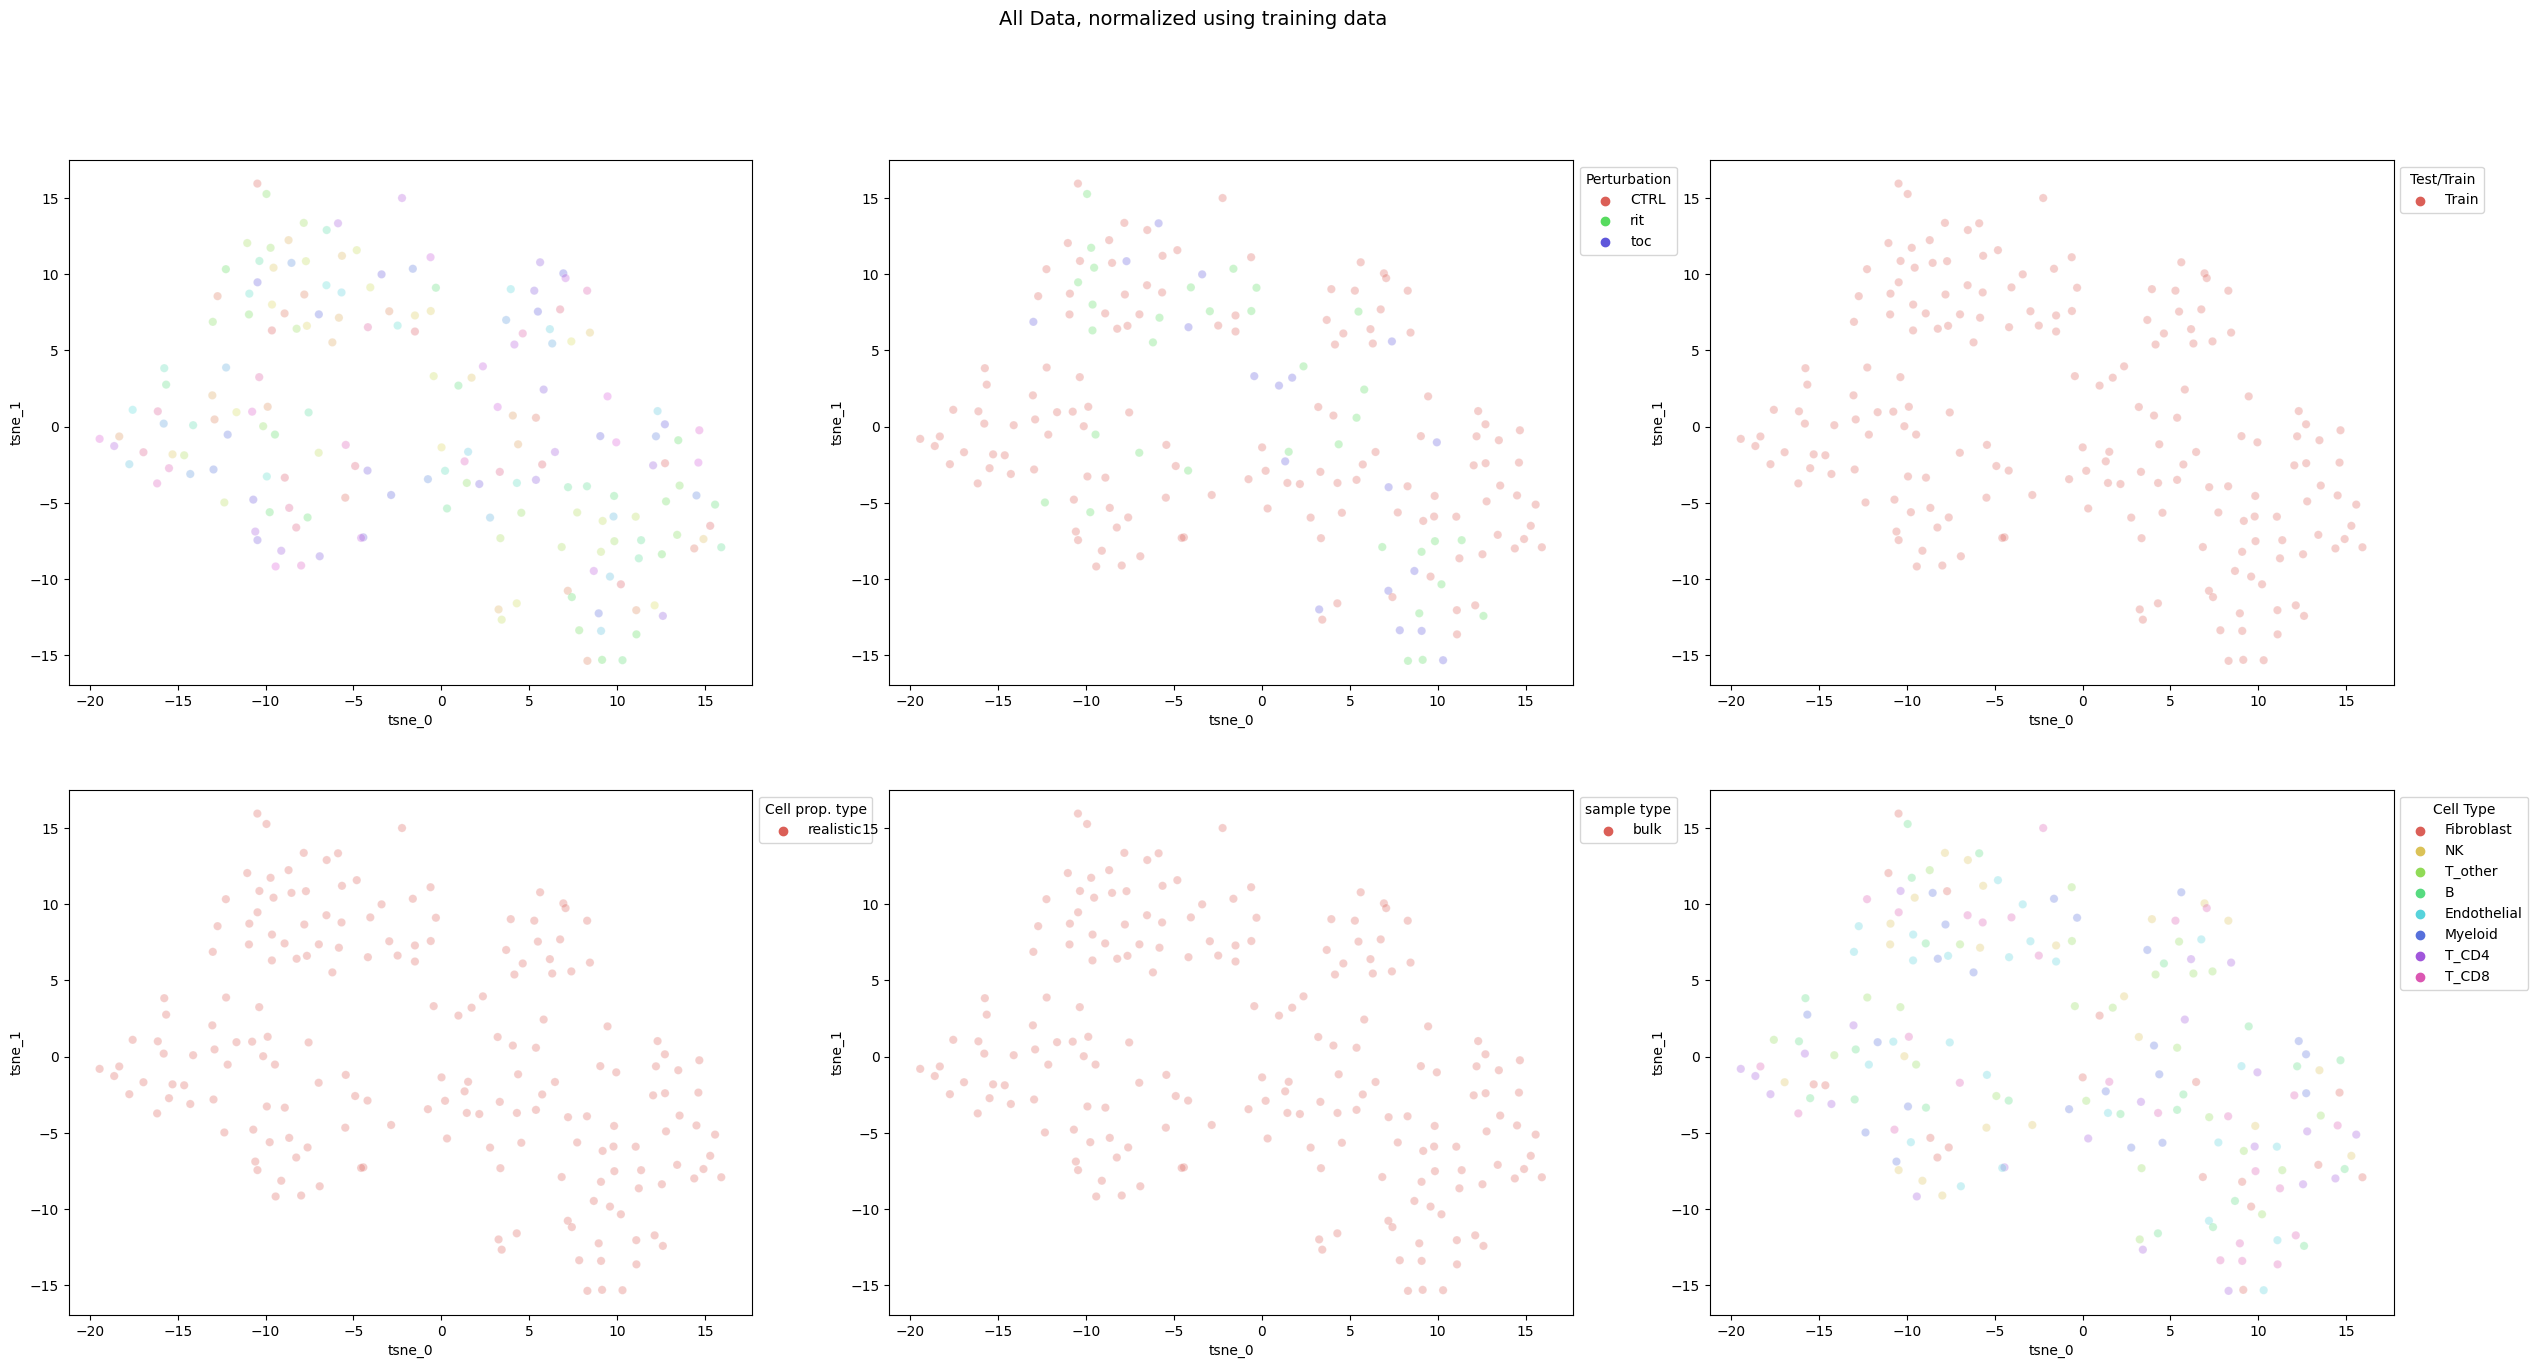

In [20]:
## plot samples
idx_interest = np.where(np.logical_and(meta_df.samp_type == "bulk", meta_df.isTraining == "Train"))[0]

plot_df = vp.get_tsne_for_plotting(X_full[idx_interest])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_interest])
Y_temp = np.argmax(Y_temp, axis=1) 
Y_temp = Y_full.columns[Y_temp]

vp.plot_tsne(plot_df, meta_df.sample_id.to_numpy()[idx_interest], axs[0,0], alpha=1, title=f"", legend_title="Sample ID")
vp.plot_tsne(plot_df, meta_df.stim.to_numpy()[idx_interest], axs[0,1], alpha=1, title=f"", legend_title="Perturbation")
vp.plot_tsne(plot_df, meta_df.isTraining.to_numpy()[idx_interest], axs[0,2], alpha=1, title=f"", legend_title="Test/Train")
vp.plot_tsne(plot_df, meta_df.cell_prop_type.to_numpy()[idx_interest], axs[1,0], alpha=1, title=f"", legend_title="Cell prop. type")
vp.plot_tsne(plot_df, meta_df.samp_type.to_numpy()[idx_interest], axs[1,1], alpha=1, title=f"", legend_title="sample type")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"", alpha=1, legend_title="Cell Type")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Read in Trained Models**

In [21]:
# pred1_model3, pred2_model1
res1_enc_unlab = tf.keras.models.load_model(f"{res_data_path}/pred3_rittoc_model3_{res_id}_encoder_unlab")
res1_enc_lab = tf.keras.models.load_model(f"{res_data_path}/pred3_rittoc_model3_{res_id}_encoder_lab")
res1_dec = tf.keras.models.load_model(f"{res_data_path}/pred3_rittoc_model3_{res_id}_decoder")
res1_classifier = tf.keras.models.load_model(f"{res_data_path}/pred3_rittoc_model3_{res_id}_classifier")



2024-02-21 07:48:01.029317: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-02-21 07:48:01.073314: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_16' id:288 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_16}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_6, Identity_16)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-21 07:48:01.660112: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_47' id:685 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_47}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](kernel_21, Identity_47)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-02-21 07:48:01.893936: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_48' id:833 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_48}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_24, Identity_48)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-02-21 07:48:02.094156: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_54' id:922 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_54}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_27, Identity_54)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an

## Do latent space projectsions

### drug perturbation

In [22]:

toc_idx = np.where(meta_df.stim != "rit")[0]
meta_df_toc = meta_df.copy()
meta_df_toc.stim.iloc[np.where(meta_df_toc.stim != "CTRL")] = "STIM"

resToc_meta_df, resToc_decoded_0_0, resToc_decoded_0_1, resToc_top_genes = buddi.calc_buddi_perturbation(meta_df_toc.iloc[toc_idx], X_full[toc_idx,:], Y_full.iloc[toc_idx], scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


rit_idx = np.where(meta_df.stim != "toc")[0]
meta_df_rit = meta_df.copy()
meta_df_rit.stim.iloc[np.where(meta_df_rit.stim != "CTRL")] = "STIM"

resRit_meta_df, resRit_decoded_0_0, resRit_decoded_0_1, resRit_top_genes = buddi.calc_buddi_perturbation(meta_df_rit.iloc[rit_idx], X_full[rit_idx,:], Y_full.iloc[rit_idx], scaler, 
                                                                            res1_enc_unlab, res1_dec, batch_size=500, 
                                                                            genes_ordered=union_genes, 
                                                                            top_lim=100, use_buddi4=True)


/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/3186588061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df_toc.stim.iloc[np.where(meta_df_toc.stim != "CTRL")] = "STIM"
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-21 07:48:03.240556: W tensorflow/c/c_api.cc:304] Operation '{name:'tf_op_layer_z_samp_slack_2/add/z_samp_slack_2/add' id:375 op device:{requested: '', assigned: ''} def:{{{node tf_op_layer_z_samp_slack_2/add/z_samp_slack_2/add}} = AddV2[T=DT_FLOAT, _cloned=true, _has_manual_control_dep

In [23]:
# make anndata for BuDDI
def make_anndata_buddi(res1_decoded_0_0, res1_decoded_0_1, res1_meta_df, union_genes):

    adata_counts = np.append(res1_decoded_0_0, res1_decoded_0_1, axis=0)
    adata_df = pd.DataFrame(adata_counts)
    adata_df.columns = union_genes

    ad_union_genes = pd.DataFrame(union_genes)
    ad_union_genes.index = union_genes

    res1_meta_df_stim = res1_meta_df.copy()
    res1_meta_df_stim.stim = "STIM"
    res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)

    adata = ad.AnnData(adata_df, obs=res1_meta_df_obs, var=ad_union_genes)

    return (adata, adata_df)


# make anndata for BayesPrism
def make_anndata_bayesprism(bp_bulk_Z_path, bp_bulk_Zmeta_path):
    
    ## get with bayesprism
    bp_bulk = pd.read_csv(bp_bulk_Z_path, delimiter="\t")
    bp_bulk_meta = pd.read_csv(bp_bulk_Zmeta_path, delimiter="\t")



    def get_stim_id(in_str):
        out_str = "STIM"
        if in_str == "week0":
            out_str = "CTRL"
            
        return(out_str)

    bp_bulk_meta['stim'] = [get_stim_id(str(x)) for x in bp_bulk_meta["time"].tolist()]



    bp_adata_df = pd.DataFrame(bp_bulk)
    bp_union_genes = bp_adata_df.columns
    bp_adata_df = bp_adata_df[bp_union_genes]

    ad_bp_union_genes = pd.DataFrame(bp_union_genes)
    ad_bp_union_genes.index = bp_union_genes


    # format meta data
    bp_bulk_meta["Y_max"] = bp_bulk_meta.cell_type


    # make anndata
    bp_adata = ad.AnnData(bp_adata_df, obs=bp_bulk_meta, var=ad_bp_union_genes)

    return (bp_adata, bp_adata_df)



## Format BuDDI and BayesPrism

In [24]:
adata_resToc, adata_resToc_df = make_anndata_buddi(resToc_decoded_0_0, resToc_decoded_0_1, resToc_meta_df, union_genes)
adata_resRit, adata_resRit_df = make_anndata_buddi(resRit_decoded_0_0, resRit_decoded_0_1, resRit_meta_df, union_genes)




/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res1_meta_df_obs = res1_meta_df.append(res1_meta_df_stim)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/var/folders/64/dljh4z4j4vq9yn4f7wkb2k1h0000gp/T/ipykernel_3031/3037078427.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


# Compare latent spaces with responder / non-responder

In [25]:
meta_df

sample_id  stim isTraining cell_prop_type samp_type       response  \
0           BRI-421  CTRL      Train         random    sc_ref  Non.Responder   
1           BRI-421  CTRL      Train         random    sc_ref  Non.Responder   
2           BRI-421  CTRL      Train         random    sc_ref  Non.Responder   
3           BRI-421  CTRL      Train         random    sc_ref  Non.Responder   
4           BRI-421  CTRL      Train         random    sc_ref  Non.Responder   
...             ...   ...        ...            ...       ...            ...   
14579  R4RAPAT00091   rit      Train      realistic      bulk  Non.Responder   
14580  R4RAPAT00092  CTRL      Train      realistic      bulk  Non.Responder   
14581  R4RAPAT00093  CTRL      Train      realistic      bulk      Responder   
14582  R4RAPAT00093   rit      Train      realistic      bulk      Responder   
14583  R4RAPAT00094  CTRL      Train      realistic      bulk      Responder   

         paired  treatment_x subject_id pipeline_date  ... tissue_type  \
0      unpaired         CTRL   300-0501       8/12/19  ...      Biopsy   
1      unpaired         CTRL   300-0501       8/12/19  ...      Biopsy   
2      unpaired         CTRL   300-0501       8/12/19  ...      Biopsy   
3      unpaired         CTRL   300-0501       8/12/19  ...      Biopsy   
4      unpaired         CTRL   300-0501       8/12/19  ...      Biopsy   
...         ...          ...        ...           ...  ...         ...   
14579    paired    Rituximab        NaN           NaN  ...         NaN   
14580  unpaired  Tocilizumab        NaN           NaN  ...         NaN   
14581    paired    Rituximab        NaN           NaN  ...         NaN   
14582    paired    Rituximab        NaN           NaN  ...         NaN   
14583    paired    Rituximab        NaN           NaN  ...         NaN   

      krenn_lining krenn_inflammation single_cell_tech  cell_count_to_10x  \
0             1.33               2.33          CITEseq             12,400   
1             1.33               2.33          CITEseq             12,400   
2             1.33               2.33          CITEseq             12,400   
3             1.33               2.33          CITEseq             12,400   
4             1.33               2.33          CITEseq             12,400   
...            ...                ...              ...                ...   
14579          NaN                NaN              NaN                NaN   
14580          NaN                NaN              NaN                NaN   
14581          NaN                NaN              NaN                NaN   
14582          NaN                NaN              NaN                NaN   
14583          NaN                NaN              NaN                NaN   

      mRNA_run  protein_run atac_run    qc        Y_max  
0      BRI-421      BRI-422      NaN  Pass   Fibroblast  
1      BRI-421      BRI-422      NaN  Pass           NK  
2      BRI-421      BRI-422      NaN  Pass      T_other  
3      BRI-421      BRI-422      NaN  Pass            B  
4      BRI-421      BRI-422      NaN  Pass  Endothelial  
...        ...          ...      ...   ...          ...  
14579      NaN          NaN      NaN   NaN      T_other  
14580      NaN          NaN      NaN   NaN           NK  
14581      NaN          NaN      NaN   NaN      Myeloid  
14582      NaN          NaN      NaN   NaN  Endothelial  
14583      NaN          NaN      NaN   NaN        T_CD4  

[14584 rows x 27 columns]

In [26]:
tab = meta_df.groupby(['paired', 'response']).size()
tab.unstack()

response  Non.Responder  Responder
paired                            
paired               54         36
unpaired          14446         48

In [27]:
tab = meta_df.groupby(['isTraining', 'stim']).size()
tab.unstack()

stim         CTRL  rit  toc
isTraining                 
Train       14533   33   18

In [28]:
idx_tmp = np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim != "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.paired == "paired")
idx_tmp = np.where(np.logical_and(idx_tmp, meta_df.treatment_x == "Rituximab"))[0]


samps_removed = ["R4RAPAT00119", "R4RAPAT00122", "R4RAPAT00124", "R4RAPAT00126",
                 "R4RAPAT00120", "R4RAPAT00121", "R4RAPAT00144"]


meta_df.iloc[idx_tmp]


sample_id stim isTraining cell_prop_type samp_type       response  \
14402  R4RAPAT00094  rit      Train      realistic      bulk      Responder   
14406  R4RAPAT00097  rit      Train      realistic      bulk  Non.Responder   
14410  R4RAPAT00100  rit      Train      realistic      bulk  Non.Responder   
14416  R4RAPAT00104  rit      Train      realistic      bulk      Responder   
14426  R4RAPAT00111  rit      Train      realistic      bulk      Responder   
14429  R4RAPAT00113  rit      Train      realistic      bulk  Non.Responder   
14434  R4RAPAT00015  rit      Train      realistic      bulk  Non.Responder   
14435  R4RAPAT00116  rit      Train      realistic      bulk      Responder   
14441  R4RAPAT00119  rit      Train      realistic      bulk  Non.Responder   
14443  R4RAPAT00120  rit      Train      realistic      bulk      Responder   
14446  R4RAPAT00121  rit      Train      realistic      bulk      Responder   
14448  R4RAPAT00122  rit      Train      realistic      bulk  Non.Responder   
14451  R4RAPAT00124  rit      Train      realistic      bulk  Non.Responder   
14454  R4RAPAT00126  rit      Train      realistic      bulk  Non.Responder   
14460  R4RAPAT00131  rit      Train      realistic      bulk  Non.Responder   
14468  R4RAPAT00137  rit      Train      realistic      bulk  Non.Responder   
14470  R4RAPAT00138  rit      Train      realistic      bulk  Non.Responder   
14472  R4RAPAT00139  rit      Train      realistic      bulk  Non.Responder   
14481  R4RAPAT00144  rit      Train      realistic      bulk      Responder   
14501  R4RAPAT00025  rit      Train      realistic      bulk      Responder   
14517  R4RAPAT00039  rit      Train      realistic      bulk  Non.Responder   
14524  R4RAPAT00045  rit      Train      realistic      bulk  Non.Responder   
14526  R4RAPAT00046  rit      Train      realistic      bulk      Responder   
14531  R4RAPAT00048  rit      Train      realistic      bulk      Responder   
14535  R4RAPAT00051  rit      Train      realistic      bulk  Non.Responder   
14538  R4RAPAT00053  rit      Train      realistic      bulk      Responder   
14550  R4RAPAT00061  rit      Train      realistic      bulk  Non.Responder   
14579  R4RAPAT00091  rit      Train      realistic      bulk  Non.Responder   
14582  R4RAPAT00093  rit      Train      realistic      bulk      Responder   

       paired treatment_x subject_id pipeline_date  ... tissue_type  \
14402  paired   Rituximab        NaN           NaN  ...         NaN   
14406  paired   Rituximab        NaN           NaN  ...         NaN   
14410  paired   Rituximab        NaN           NaN  ...         NaN   
14416  paired   Rituximab        NaN           NaN  ...         NaN   
14426  paired   Rituximab        NaN           NaN  ...         NaN   
14429  paired   Rituximab        NaN           NaN  ...         NaN   
14434  paired   Rituximab        NaN           NaN  ...         NaN   
14435  paired   Rituximab        NaN           NaN  ...         NaN   
14441  paired   Rituximab        NaN           NaN  ...         NaN   
14443  paired   Rituximab        NaN           NaN  ...         NaN   
14446  paired   Rituximab        NaN           NaN  ...         NaN   
14448  paired   Rituximab        NaN           NaN  ...         NaN   
14451  paired   Rituximab        NaN           NaN  ...         NaN   
14454  paired   Rituximab        NaN           NaN  ...         NaN   
14460  paired   Rituximab        NaN           NaN  ...         NaN   
14468  paired   Rituximab        NaN           NaN  ...         NaN   
14470  paired   Rituximab        NaN           NaN  ...         NaN   
14472  paired   Rituximab        NaN           NaN  ...         NaN   
14481  paired   Rituximab        NaN           NaN  ...         NaN   
14501  paired   Rituximab        NaN           NaN  ...         NaN   
14517  paired   Rituximab        NaN           NaN  ...         NaN   
14524  paired   Rituximab        NaN           NaN  ...         NaN   
14526 

In [29]:
idx_tmp = np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic")
idx_tmp = np.logical_and(idx_tmp, meta_df.stim == "CTRL")
idx_tmp = np.logical_and(idx_tmp, meta_df.paired == "paired")
idx_tmp = np.where(np.logical_and(idx_tmp, meta_df.treatment_x == "Tocilizumab"))[0]

np.random.choice(meta_df.sample_id.iloc[idx_tmp], 4, replace=False)


samps_removed = ["R4RAPAT00118", "R4RAPAT00142",
                  "R4RAPAT00047", "R4RAPAT00060"]



meta_df.iloc[idx_tmp]


sample_id  stim isTraining cell_prop_type samp_type       response  \
14407  R4RAPAT00099  CTRL      Train      realistic      bulk  Non.Responder   
14418  R4RAPAT00107  CTRL      Train      realistic      bulk  Non.Responder   
14422  R4RAPAT00110  CTRL      Train      realistic      bulk      Responder   
14430  R4RAPAT00114  CTRL      Train      realistic      bulk  Non.Responder   
14436  R4RAPAT00117  CTRL      Train      realistic      bulk  Non.Responder   
14438  R4RAPAT00118  CTRL      Train      realistic      bulk  Non.Responder   
14457  R4RAPAT00129  CTRL      Train      realistic      bulk      Responder   
14473  R4RAPAT00140  CTRL      Train      realistic      bulk      Responder   
14476  R4RAPAT00142  CTRL      Train      realistic      bulk  Non.Responder   
14482  R4RAPAT00145  CTRL      Train      realistic      bulk  Non.Responder   
14502  R4RAPAT00027  CTRL      Train      realistic      bulk      Responder   
14527  R4RAPAT00047  CTRL      Train      realistic      bulk      Responder   
14542  R4RAPAT00056  CTRL      Train      realistic      bulk  Non.Responder   
14547  R4RAPAT00060  CTRL      Train      realistic      bulk      Responder   
14555  R4RAPAT00066  CTRL      Train      realistic      bulk  Non.Responder   
14561  R4RAPAT00072  CTRL      Train      realistic      bulk  Non.Responder   

       paired  treatment_x subject_id pipeline_date  ... tissue_type  \
14407  paired  Tocilizumab        NaN           NaN  ...         NaN   
14418  paired  Tocilizumab        NaN           NaN  ...         NaN   
14422  paired  Tocilizumab        NaN           NaN  ...         NaN   
14430  paired  Tocilizumab        NaN           NaN  ...         NaN   
14436  paired  Tocilizumab        NaN           NaN  ...         NaN   
14438  paired  Tocilizumab        NaN           NaN  ...         NaN   
14457  paired  Tocilizumab        NaN           NaN  ...         NaN   
14473  paired  Tocilizumab        NaN           NaN  ...         NaN   
14476  paired  Tocilizumab        NaN           NaN  ...         NaN   
14482  paired  Tocilizumab        NaN           NaN  ...         NaN   
14502  paired  Tocilizumab        NaN           NaN  ...         NaN   
14527  paired  Tocilizumab        NaN           NaN  ...         NaN   
14542  paired  Tocilizumab        NaN           NaN  ...         NaN   
14547  paired  Tocilizumab        NaN           NaN  ...         NaN   
14555  paired  Tocilizumab        NaN           NaN  ...         NaN   
14561  paired  Tocilizumab        NaN           NaN  ...         NaN   

      krenn_lining krenn_inflammation single_cell_tech  cell_count_to_10x  \
14407          NaN                NaN              NaN                NaN   
14418          NaN                NaN              NaN                NaN   
14422          NaN                NaN              NaN                NaN   
14430          NaN                NaN              NaN                NaN   
14436          NaN                NaN              NaN                NaN   
14438          NaN                NaN              NaN                NaN   
14457          NaN                NaN              NaN                NaN   
14473          NaN                NaN              NaN                NaN   
14476          NaN                NaN              NaN                NaN   
14482          NaN                NaN              NaN                NaN   
14502          NaN                NaN              NaN                NaN   
14527          NaN                NaN              NaN                NaN   
14542          NaN                NaN              NaN                NaN   
14547          NaN                NaN              NaN                NaN   
14555          NaN                NaN              NaN                NaN   
14561          NaN                NaN              NaN                NaN   

      mRNA_run  protein_run atac_run   qc        Y_max  
14407      NaN          NaN      NaN  NaN            B  


In [30]:
# subset the data to the training data
# to show our latent spaces are learning appropriately

idx_tmp = np.logical_and(meta_df.isTraining == "Train", meta_df.cell_prop_type == "realistic")
idx_tmp = np.where(np.logical_and(idx_tmp, meta_df.stim == "CTRL"))[0]
idx_tmp = np.tile(idx_tmp, 100)[0:5000]

meta_df["response_treatment"] = meta_df["response"] + meta_df["treatment_x"]
samp_responder = np.asarray(meta_df.response)
index_resp, numeric_resp= np.unique(samp_responder, return_inverse=True)
Resp_full = numeric_resp
resp_full = to_categorical(numeric_resp)

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_full)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]
Y_temp = Y_full.columns[Y_temp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]
label_temp = index_label[label_temp]

perturb_temp =np.copy(Resp_full)
perturb_temp = perturb_temp[idx_tmp]
perturb_temp = index_resp[perturb_temp]


bulk_temp = np.copy(Bulk_full)
bulk_temp = bulk_temp[idx_tmp]


In [31]:
z_slack, mu_slack, _, z_rot, mu_rot, _, z_drug, mu_drug, _, z_bulk, mu_bulk, _ = res1_enc_unlab.predict(X_temp, batch_size=500)
prop_outputs_test = res1_classifier.predict(X_temp, batch_size=500)


/Users/davidnat/Documents/projects/greenelab/buddi_test/.venv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-02-21 07:48:27.988380: W tensorflow/c/c_api.cc:304] Operation '{name:'cls_out/Softmax' id:943 op device:{requested: '', assigned: ''} def:{{{node cls_out/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](cls_out/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [32]:
meta_df.sample_id.iloc[idx_tmp]

14400    R4RAPAT00002
14401    R4RAPAT00013
14403    R4RAPAT00095
14404    R4RAPAT00096
14405    R4RAPAT00097
             ...     
14509    R4RAPAT00032
14510    R4RAPAT00033
14511    R4RAPAT00034
14512    R4RAPAT00035
14513    R4RAPAT00036
Name: sample_id, Length: 5000, dtype: object

In [33]:
meta_df.sample_id.iloc[idx_tmp][0:133]

14400    R4RAPAT00002
14401    R4RAPAT00013
14403    R4RAPAT00095
14404    R4RAPAT00096
14405    R4RAPAT00097
             ...     
14577    R4RAPAT00090
14578    R4RAPAT00091
14580    R4RAPAT00092
14581    R4RAPAT00093
14583    R4RAPAT00094
Name: sample_id, Length: 133, dtype: object

In [34]:


samples_test = ["R4RAPAT00131", "R4RAPAT00137", "R4RAPAT00138", "R4RAPAT00139",
                 "R4RAPAT00025", "R4RAPAT00046", "R4RAPAT00048", "R4RAPAT00118", 
                 "R4RAPAT00142", "R4RAPAT00047", "R4RAPAT00060"]


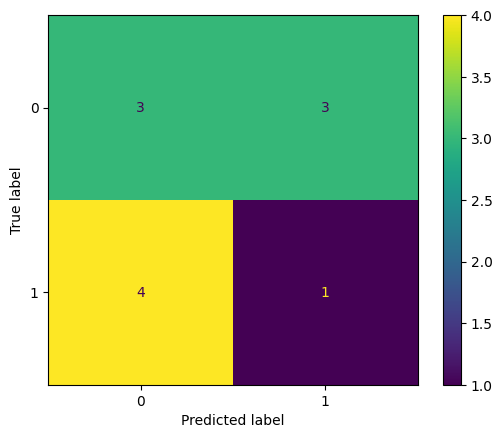

Test: 0.36363636363636365
Train: 0.9836065573770492
0.36363636363636365
              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.25      0.20      0.22         5

    accuracy                           0.36        11
   macro avg       0.34      0.35      0.34        11
weighted avg       0.35      0.36      0.35        11



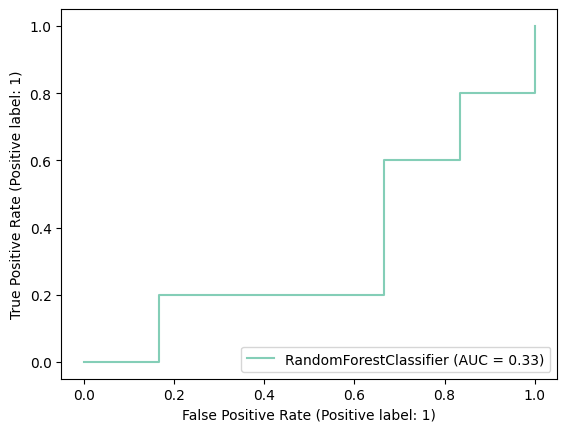

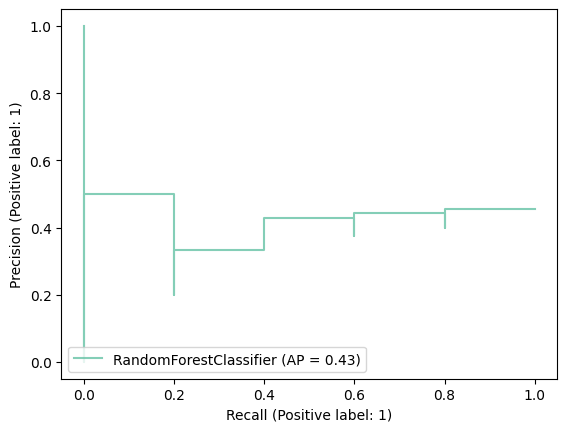

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


curr_drug = mu_drug[0:133]
curr_label = numeric_resp[idx_tmp][0:133]
curr_samp_ids = meta_df.sample_id.iloc[idx_tmp][0:133]

test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()


print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))



ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

ax = plt.gca()
rfc_disp = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()



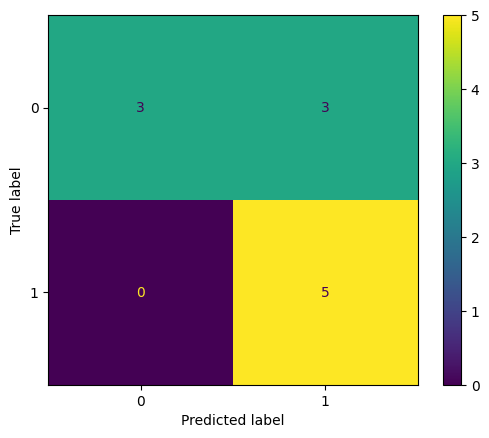

Test: 0.7272727272727273
Train: 1.0
0.7272727272727273
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.62      1.00      0.77         5

    accuracy                           0.73        11
   macro avg       0.81      0.75      0.72        11
weighted avg       0.83      0.73      0.71        11



In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


curr_drug = mu_rot[0:133]
curr_label = numeric_resp[idx_tmp][0:133]

test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()


print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


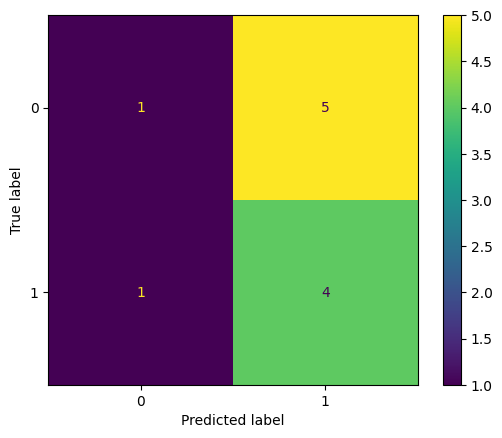

Test: 0.45454545454545453
Train: 0.7540983606557377
0.45454545454545453
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.44      0.80      0.57         5

    accuracy                           0.45        11
   macro avg       0.47      0.48      0.41        11
weighted avg       0.47      0.45      0.40        11



In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

curr_drug = mu_slack[0:133]
curr_label = numeric_resp[idx_tmp][0:133]

test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()


print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


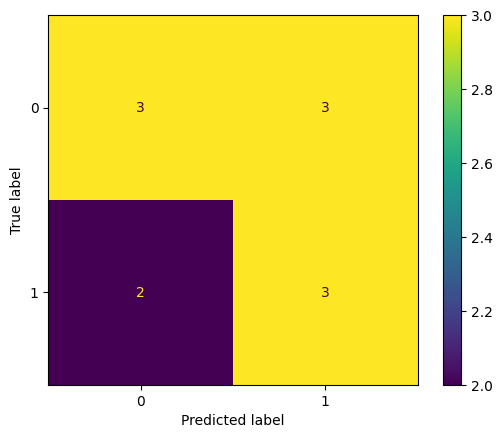

Test: 0.5454545454545454
Train: 1.0
0.5454545454545454
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.50      0.60      0.55         5

    accuracy                           0.55        11
   macro avg       0.55      0.55      0.55        11
weighted avg       0.55      0.55      0.55        11



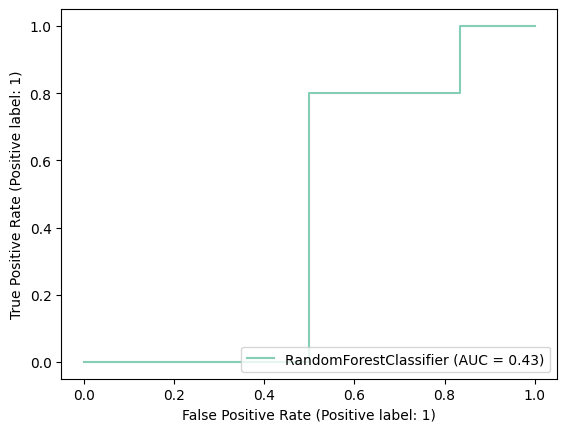

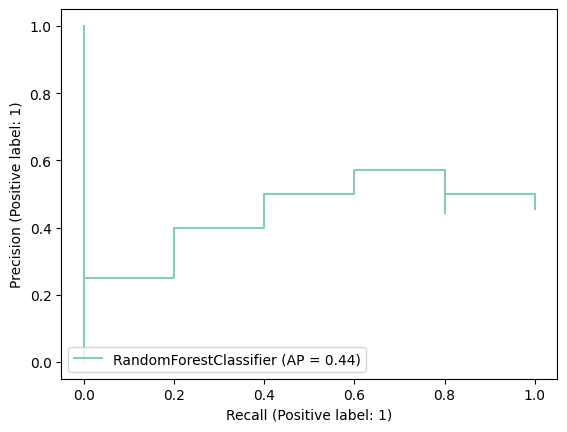

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

curr_drug = mu_bulk[0:133]
curr_label = numeric_resp[idx_tmp][0:133]


test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()


print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

ax = plt.gca()
rfc_disp = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()


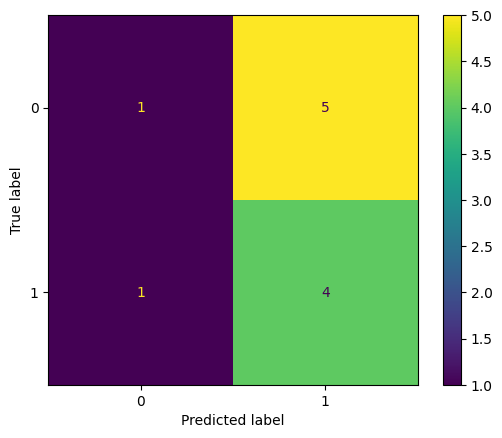

Test: 0.45454545454545453
Train: 0.9672131147540983
0.45454545454545453
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.44      0.80      0.57         5

    accuracy                           0.45        11
   macro avg       0.47      0.48      0.41        11
weighted avg       0.47      0.45      0.40        11



In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

curr_drug = prop_outputs_test[0:133]
curr_label = numeric_resp[idx_tmp][0:133]

test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()

print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))



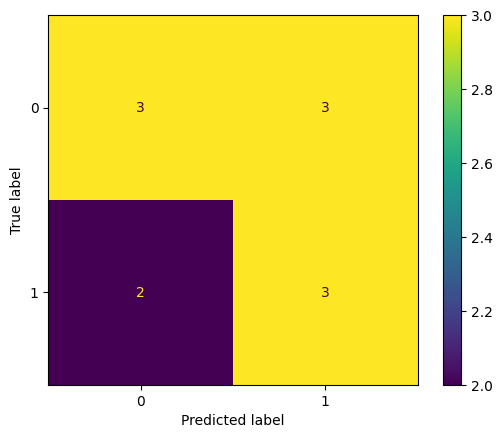

Test: 0.5454545454545454
Train: 1.0
0.5454545454545454
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.50      0.60      0.55         5

    accuracy                           0.55        11
   macro avg       0.55      0.55      0.55        11
weighted avg       0.55      0.55      0.55        11



In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

curr_drug = np.hstack((mu_bulk[0:133], mu_rot[0:133]))
curr_label = numeric_resp[idx_tmp][0:133]

test_idx = np.where(np.isin(curr_samp_ids, samples_test))[0]
train_idx = np.where(np.isin(curr_samp_ids, samples_test, invert=True))[0]

X_train = curr_drug[train_idx]
y_train = curr_label[train_idx]

X_test = curr_drug[test_idx]
y_test = curr_label[test_idx]

clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)

disp.plot()
plt.show()


print(f"Test: {clf.score(X_test, y_test)}")
print(f"Train: {clf.score(X_train, y_train)}")

print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))


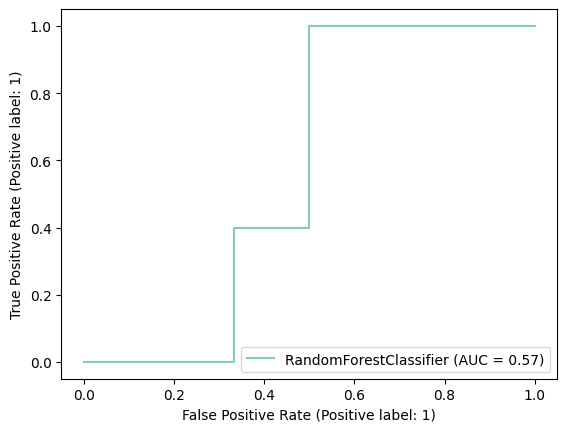

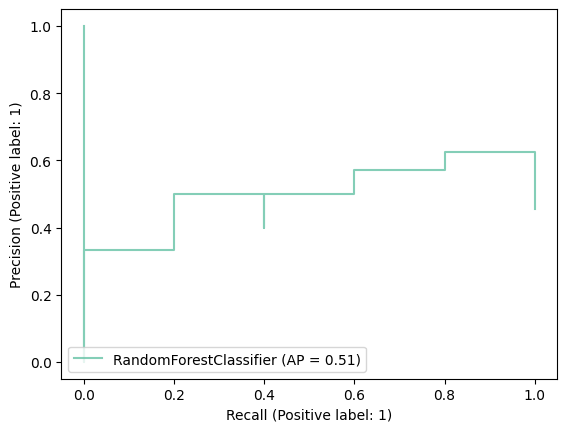

In [41]:


ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

ax = plt.gca()
rfc_disp = PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, ax=ax, alpha=0.8)
plt.show()

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)


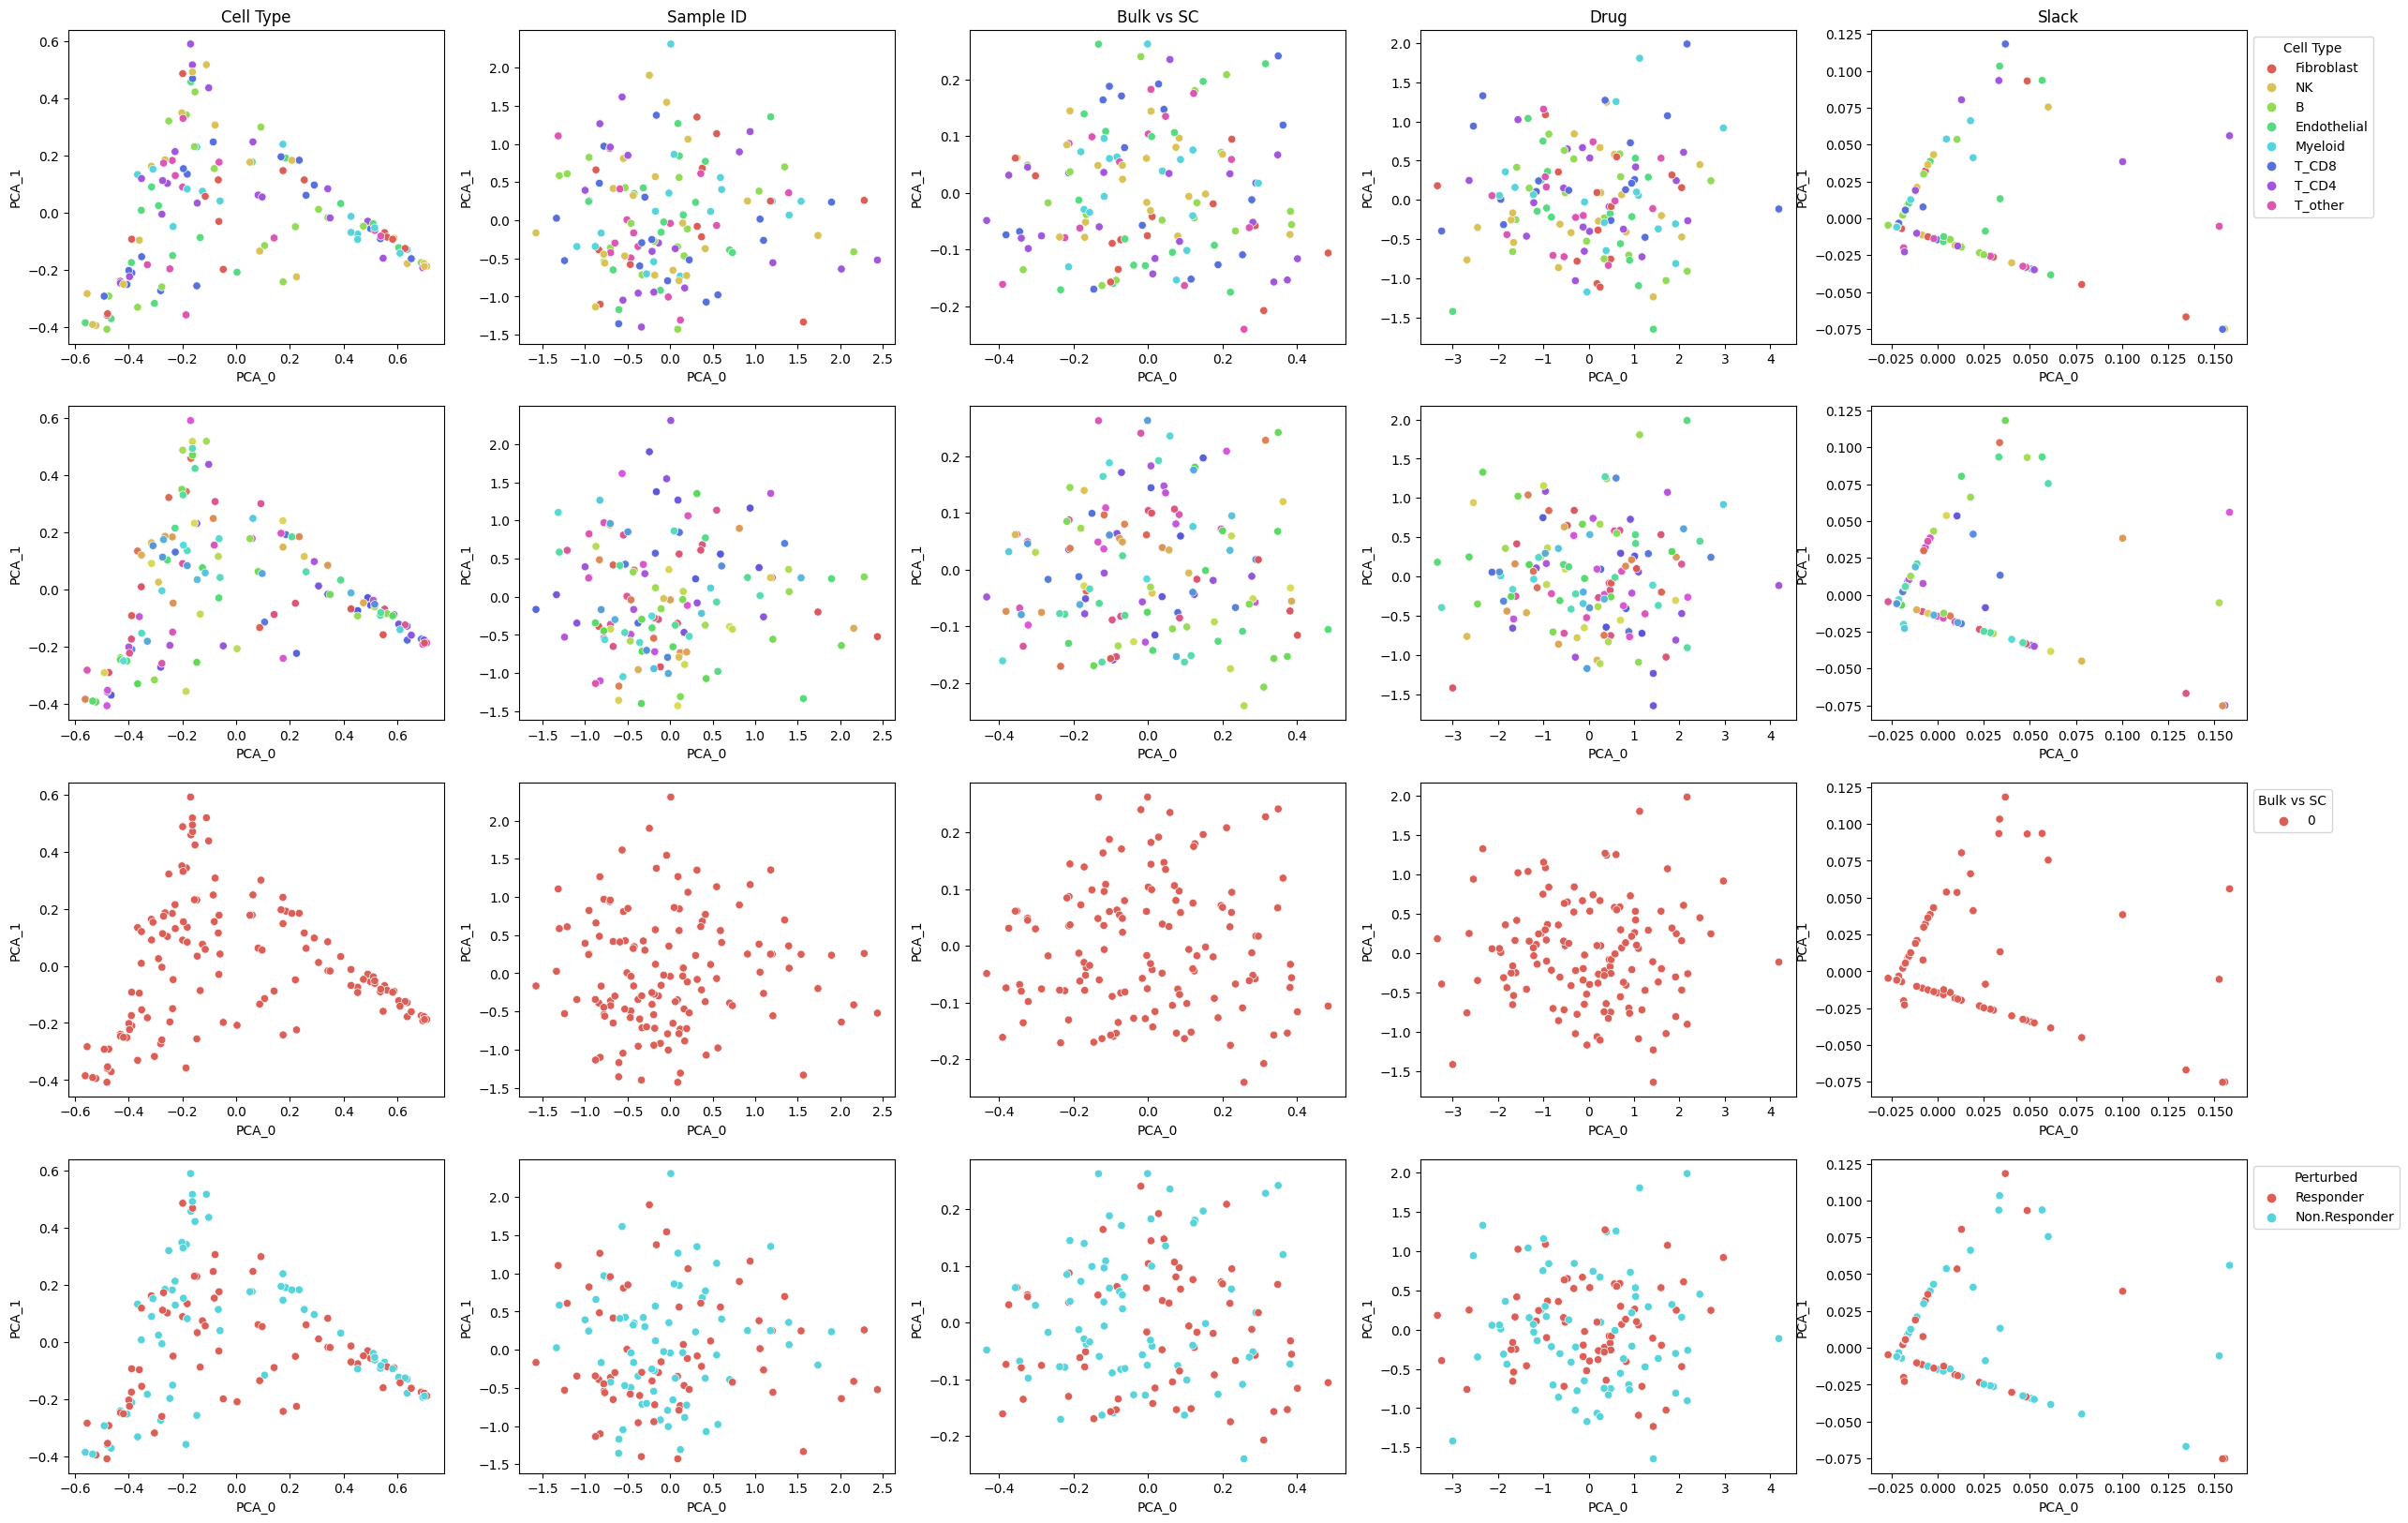

In [42]:

res1_latent_plot = buddi.plot_latent_spaces(res1_enc_unlab, res1_classifier,
                        X_temp, Y_temp, label_temp, perturb_temp, bulk_temp, 
                        batch_size=500, use_buddi4=True, hide_sample_ids=True, use_pca=True)